In [1]:
import sys
import os
from scipy import stats
import itertools
import numpy as np
from colour import Color
import matplotlib.pyplot as plt
from collections import Counter
import plotly.graph_objects as go

In [4]:
def mix_colors(c1, c2):
    c1 = np.array(c1)
    c2 = np.array(c2)
    return np.mean((c1, c2), axis=0)

In [5]:
color_companies = {}

In [6]:
colors = {
    "#" : "white",
    "_" : "green",
    "M" : "orange"
}

In [7]:
def get_coor(plansza):
    return len(plansza), len(plansza[0])

In [8]:
def draw(image, title, name=None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    if name is not None:
        plt.savefig(name, bbox_inches='tight')
    plt.show()

In [75]:
def daj_kolorowa_plansze(plansza, dict_kolorow):
    H, W = get_coor(plansza)
    
    image = np.zeros(H*W*3)
    image = image.reshape((H, W, 3))
    
    for x in range(H):
        for y in range(W):
            if isinstance(plansza[x][y], str):
                image[x][y] = Color(dict_kolorow[plansza[x][y]]).rgb
            else:
                image[x][y] = np.array(plansza[x][y]) #* 255
                #image[x][y] = dict_kolorow[plansza[x][y]]
    return image

In [18]:
def draw_plansza(plansza, colors, test, name=""):
    image = daj_kolorowa_plansze(plansza, colors)
    
    if name == "":
        name = test.split(".")[0] + ".png"
    draw(image, test, name)

In [19]:
def read_input(test_path):
    print(test_path)
    plansza = []
    skills = {}
    companies = {}
    companies_simple = []
    bonuses = []
    nums_skills = []
    mngr_bonuses = []
    skills_by_developer = []
    skills_to_companies = {}
    with open(test_path, "r") as f:
        n, m = [int(a) for a in f.readline().split(" ")]
        for i in range(m):
            plansza.append(f.readline().strip())
        devs = int(f.readline())
        for i in range(devs):
            l = f.readline().strip().split(" ")
            company = l[0]
            companies_simple.append(company)
            if company not in color_companies:
                color_companies[company] = np.random.rand(3) * 0.7
            b = int(l[1])
            bonuses.append(b)
            num_s = int(l[2])
            nums_skills.append(num_s)
            if company in companies:
                companies[company].append(i)
            else:
                companies[company] = [i]
            skills_by_developer.append(l[3:])
            assert(len(l[3:]) == len(set(l[3:])))
            
            for skill in l[3:]:                
                if skill in skills:
                    skills[skill].append(i)
                    skills_to_companies[skill].add(company)
                else:
                    skills[skill] = [i]
                    skills_to_companies[skill] = {company}
        mngrs = int(f.readline())
        for i in range(mngrs):
            company, bonus = f.readline().strip().split(" ")
            bonus = int(bonus)
            companies[company].append(i+devs)
            companies_simple.append(company)
            mngr_bonuses.append(bonus)
            bonuses.append(bonus)
            skills_by_developer.append([])
    return {
        "plansza": plansza,
        "skills": skills,
        "bonuses": bonuses,
        "mngr_bonuses": mngr_bonuses,
        "skills_by_developer": skills_by_developer,
        "skills_to_companies": skills_to_companies,
        "nums_skills": nums_skills,
        "devs": devs,
        "mngrs": mngrs,
        "companies": companies,
        "companies_simple": companies_simple
    }

In [20]:
def read_output(test_path):
    with open(test_path, "r") as f:
        x = f.readlines()
    x = [a.strip().split(" ") for a in x]
    x = [a if len(a) == 2 else [] for a in x]
    x = [[int(b) for b in a] for a in x]
    return {"coordinates" : x}

In [28]:
def get_placement(INPUT, OUTPUT):
    H, W = get_coor(INPUT["plansza"])
    image = np.zeros(H*W*3)
    image = image.reshape((H, W, 3)) 
    
    x = [[-2 if INPUT["plansza"][i][j] != "#" else -1 for j in range(W)] for i in range(H)]
    for i in range(len(OUTPUT["coordinates"])):
        if len(OUTPUT["coordinates"][i]) > 0:
            a, b = OUTPUT["coordinates"][i]
            x[b][a] = i
    for i in range(H):
        for j in range(W):
            if x[i][j] == -1:
                image[i][j] = np.array([1,1,1])
            elif x[i][j] == -2:
                image[i][j] = np.array([0.95, 0.95, 0.95])
            else:
                image[i][j] = np.array(color_companies[INPUT["companies_simple"][x[i][j]]])
    return image

In [29]:
def dict_to_text(d):
    l = []
    for k,v in d.items():
        l.append("<b>{}</b>: {}<br>".format(k, v))
    return "".join(l) 

In [62]:
def prepare_text(INPUT, OUTPUT):
    H, W = get_coor(INPUT["plansza"])
    
    data = [[{} for j in range(W)] for i in range(H)]
    
    ct = {
        "_": "dev",
        "#": "empty",
        "M": "manager"
    }
    
    for i in range(H):
        for j in range(W):
            data[i][j]["xy"] = "{} {}".format(i, j)
            data[i][j]["cell type"] = ct[INPUT["plansza"][i][j]]
    for i in range(len(OUTPUT["coordinates"])):
        if len(OUTPUT["coordinates"][i]) > 0:
            b, a = OUTPUT["coordinates"][i]
            data[a][b]["status"] = "occupied"
            data[a][b]["worker_id"] = i
            data[a][b]["bonus"] = INPUT["bonuses"][i]
            data[a][b]["company"] = INPUT["companies_simple"][i]
    
    for i in range(H):
        for j in range(W):
            data[i][j] = dict_to_text(data[i][j])
    return data

In [79]:
def plotly_draw(INPUT, OUTPUT):
    DATA = prepare_text(INPUT, OUTPUT)
    image = get_placement(INPUT, OUTPUT)
    image = image * 255
    
    fig = go.Figure(go.Image(z=image, text=DATA, hovertemplate="%{text}<extra></extra>"))
    fig.update_layout(
        hoverlabel_align = 'right',
        title = "c",
        autosize=False,
#         width=image.shape[1] * 4,
#         height=image.shape[0] * 4,
        width=900,
        height=900,
        
        xaxis_visible=False,
        yaxis_visible=False
    )

    fig.show()

In [81]:
INPUT = read_input("b_dream.txt")
OUTPUT = read_output("out-16.txt")
plotly_draw(INPUT, OUTPUT)

b_dream.txt


b_dream.txt


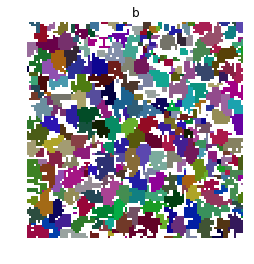

In [76]:
INPUT = read_input("b_dream.txt")
OUTPUT = read_output("out-16.txt")
plansza = get_placement(INPUT, OUTPUT)
draw(daj_kolorowa_plansze(plansza, None), "b", "aaa_b.png")

In [ ]:
for test in tests:
    print(test)
    plansza = []
    skills = {}
    companies = {}
    bonuses = []
    nums_skills = []
    mngr_bonuses = []
    skills_by_developer = []
    skills_to_companies = {}
    with open(test, "r") as f:
        n, m = [int(a) for a in f.readline().split(" ")]
        for i in range(m):
            plansza.append(f.readline().strip())
        devs = int(f.readline())
        for i in range(devs):
            l = f.readline().strip().split(" ")
            company = l[0]
            if company not in color_companies:
                color_companies[color] = np.random.rand(3) / 2 + 0.5
            b = int(l[1])
            bonuses.append(b)
            num_s = int(l[2])
            nums_skills.append(num_s)
            if company in companies:
                companies[company].append(i)
            else:
                companies[company] = [i]
            skills_by_developer.append(l[3:])
            assert(len(l[3:]) == len(set(l[3:])))
            
            for skill in l[3:]:
                
                if skill in skills:
                    skills[skill].append(i)
                    skills_to_companies[skill].add(company)
                else:
                    skills[skill] = [i]
                    skills_to_companies[skill] = {company}
        mngrs = int(f.readline())
        for i in range(mngrs):
            c, b = f.readline().strip().split(" ")
            b = int(b)
            companies[c].append(i+devs)
            mngr_bonuses.append(b)
            bonuses.append(b)
            skills_by_developer.append([])
    #draw_plansza(plansza, test)

    # print(plansza)
    # print(skills)
    # print(companies)
    
#     if test[0] == "f":
#         mima = []
#         for k, v in companies.items():
#             a = [x-devs for x in v if x >= devs]
#             a = [mngr_bonuses[x] for x in a]
#             mima.append((min(a), max(a)))
#         print(Counter(mima))
        
                
    
    
    print("H={}\nW={}".format(len(plansza), len(plansza[0])))
    devs_tiles = sum([sum([x == "_" for x in a]) for a in plansza])
    pm_tiles = sum([sum([x == "M" for x in a]) for a in plansza])
    print("Pola devow={}".format(devs_tiles))
    print("Pola managerow={}".format(pm_tiles))
    print("Liczba devow={}".format(devs))
    print("Liczba mangerow={}".format(mngrs))
    
#     plt.hist(bonuses)
#     plt.show()
    
    
    print("Number of skills = {}".format(len(skills)))
    print("Number of companies = {}".format(len(companies)))
    pyk = [len(v) for k,v in skills.items()]
#     plt.hist(pyk, bins=50)
#     plt.show()

#     plt.hist(nums_skills)
#     plt.show()
    
    pyk = [len(v) for k,v in companies.items()]
    print("min in company = {}\nmax in company = {}".format(
        min(pyk), max(pyk)
    ))
    
#     for k,v in companies.items():
#         dis_skilz = [skills_by_developer[a] for a in v if a < devs]
#         un = set(itertools.chain(*dis_skilz))
#         #print(un)
#         print(len(un), len(v))
        
    print("diff skills={}".format(len(skills)))
    
    if test[0] == "e":
        for c, v in companies.items(): 
            if len(skills_by_developer[v[0]]) >= 10:
                for i in range(len(v)):
                    for j in range(len(v)):
                        x = set(skills_by_developer[v[i]])
                        y = set(skills_by_developer[v[j]])
                        print(len(x.intersection(y)), end=" ")
                    print("")
                print("")
                print("", flush=True)
                    
#             w = v
#             for a in w:
#             len(skills_by_developer[a]), bonuses[a], end=" | ")
            
#             x = [len(lol) for lol in skills_by_developer]
#             y = bonuses
#             print(x[:100], y[:100])
#             print("corr", stats.pearsonr(x, y))
    
    
#     for i in range(devs):
#         print(len(skills_by_developer[i]), bonuses[i])
        
    
#     for s in skills_to_companies:
#         w = skills[s]
#         v = skills_to_companies[s]
#         print(len(v), len(w))
    
#     if test[0] in "ce":
#         print(sorted(pyk))
    
#     plt.hist(pyk)
#     plt.show()
    print("")